In [44]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas.
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [45]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**VARIABLE DESCRIPTION**
 * **Survived** - Survival (0 = No; 1 = Yes);
 * **Pclass** - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);
 * **Name** - Name;
 * **Sex** - Sex;
 * **Age** - Age;
 * **SibSp** - Number of Siblings/Spouses Aboard;
 * **Parch** - Number of Parents/Children Aboard;
 * **Ticket** - Ticket Number;
 * **Fare** - Passenger Fare (British pound);
 * **Cabin** - Cabin;
 * **Embarked** - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.


/var/folders/xz/khfgvmxj4tsd1nl_m4gdk7780000gn/T/ipykernel_75928/1762291817.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='Survived',data=titanic, palette='hls')


<Axes: xlabel='Survived', ylabel='count'>

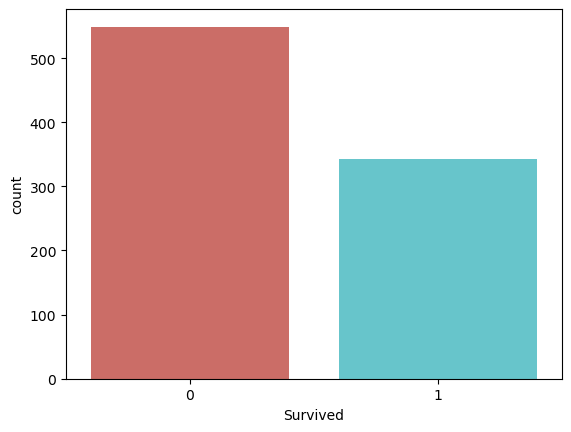

In [46]:
sb.countplot(x='Survived',data=titanic, palette='hls')

###Checking for missing values
É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variáveis

In [47]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [48]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa variável completamente! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

## Lidando com missing values
#### Removendo missing values
Vamos além dos missing values... Vamos descartar todas as variáveis que não são relevantes para a predição de Survived.

In [49]:
titanic.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)


In [50]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [51]:
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

## Imputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

/var/folders/xz/khfgvmxj4tsd1nl_m4gdk7780000gn/T/ipykernel_75928/1502893441.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='Pclass', y='Age', data=titanic, palette='hls')


<Axes: xlabel='Pclass', ylabel='Age'>

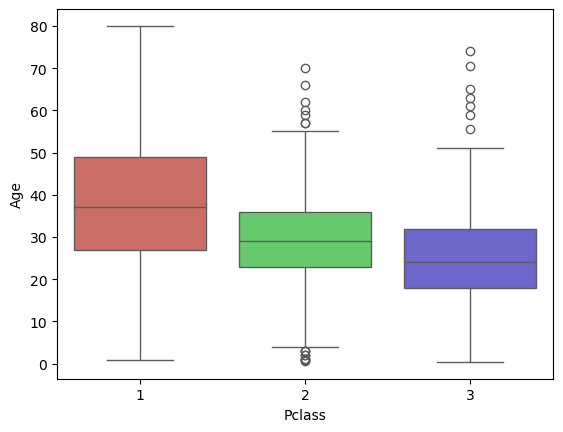

In [52]:
sb.boxplot(x='Pclass', y='Age', data=titanic, palette='hls')

Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [53]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age


Após definir a função, vamos executar apenas para os valores nulos de Age

In [54]:
titanic[['Age', 'Pclass']]

,Age,Pclass
0,22.0,3
1,38.0,1
2,26.0,3
3,35.0,1
4,35.0,3
...,...,...
886,27.0,2
887,19.0,1
888,NaN,3
889,26.0,1


In [55]:
titanic[['Age', 'Pclass']].apply(age_approx, axis=1)

/var/folders/xz/khfgvmxj4tsd1nl_m4gdk7780000gn/T/ipykernel_75928/1331469511.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
/var/folders/xz/khfgvmxj4tsd1nl_m4gdk7780000gn/T/ipykernel_75928/1331469511.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    24.0
889    26.0
890    32.0
Length: 891, dtype: float64

In [56]:
titanic['Age'] = titanic[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic.isnull().sum()

/var/folders/xz/khfgvmxj4tsd1nl_m4gdk7780000gn/T/ipykernel_75928/1331469511.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
/var/folders/xz/khfgvmxj4tsd1nl_m4gdk7780000gn/T/ipykernel_75928/1331469511.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.

In [57]:
titanic.dropna(inplace=True)
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [58]:

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


### Convertendo variaveis categóricas com one-hot-enconding (via pandas usa-se a função get_dummies)

In [59]:
aux = pd.get_dummies(titanic['Sex'],drop_first=False)
aux.head()

,female,male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True


In [60]:
gender = pd.get_dummies(titanic['Sex'],drop_first=True)
gender.head()

,male
0,True
1,False
2,False
3,False
4,True


In [61]:
embark_location = pd.get_dummies(titanic['Embarked'],drop_first=True)
embark_location.head(10)

,Q,S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True
5,True,False
6,False,True
7,False,True
8,False,True
9,False,False


In [62]:
titanic.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic.head()

titanic_dmy = pd.concat([titanic,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [63]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   male      889 non-null    bool   
 7   Q         889 non-null    bool   
 8   S         889 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 51.2 KB


### Agora Vamos Classificar!
1º: Separar o conjunto em variável resposta e variáveis de treinamento

In [64]:
X = titanic_dmy.iloc[:,[1,2,3,4,5,6,7,8]].values
y = titanic_dmy.iloc[:,0].values

In [65]:
#X = titanic_dmy[['Age',	'SibSp',	'Parch',	'Fare',	'male'	,'S']].values
#y = titanic_dmy['Survived'].values

In [66]:
X

array([[3, 22.0, 1, ..., True, False, True],
       [1, 38.0, 1, ..., False, False, False],
       [3, 26.0, 0, ..., False, False, True],
       ...,
       [3, 24.0, 1, ..., False, False, True],
       [1, 26.0, 0, ..., True, False, False],
       [3, 32.0, 0, ..., True, True, False]], dtype=object)

In [67]:
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

Agora dividir em treino e teste (teste com 30%)

In [68]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size = .3, random_state=25)

Normalização do Conjunto

**Pergunta**: Devemos treinar o Scaler em qual conjunto de dados (completo, train ou teste)?

In [69]:
scaler = MinMaxScaler().fit(X_train_orig)

X_train = scaler.transform(X_train_orig)
X_test = scaler.transform(X_test_orig)
y_train = y_train_orig

In [70]:
X_train

array([[0.        , 0.41560207, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 0.32046752, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.5       , 0.32046752, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.49714596, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.53791791, 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.38842077, 0.125     , ..., 0.        , 0.        ,
        1.        ]])

In [71]:
X_test

array([[0.        , 0.44278337, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.5       , 0.37483012, 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.33405817, 0.125     , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.5       , 0.55150856, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.5       , 0.37483012, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 0.23892362, 0.        , ..., 0.        , 0.        ,
        1.        ]])

Criação do modelo knn com o valor de k =




In [72]:
Classif_KNN = KNeighborsClassifier(n_neighbors=1)

Processo de treinamento com 70% dos dados

In [73]:
Classif_KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Processo de teste com 30% dos dados que não foram utilizados no treinamento

In [74]:
y_pred = Classif_KNN.predict(X_test)

In [75]:
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1])

In [76]:
y_test_orig

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1])

###Avaliando o modelo
Analisando o rotulo real com o rotulo predito

In [77]:
print(classification_report(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       164
           1       0.66      0.73      0.69       103

    accuracy                           0.75       267
   macro avg       0.74      0.75      0.74       267
weighted avg       0.76      0.75      0.75       267



In [78]:
print(accuracy_score(y_test_orig, y_pred))

0.7528089887640449


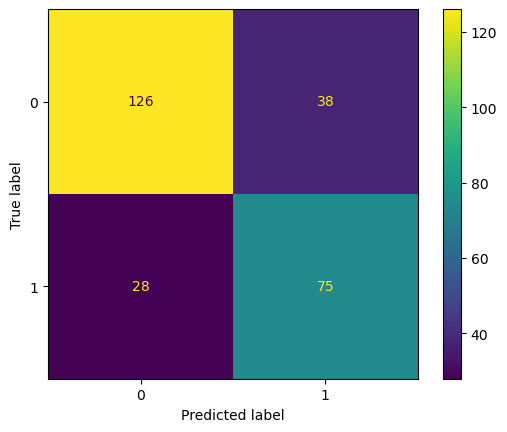

In [79]:
cm = confusion_matrix( y_test_orig, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

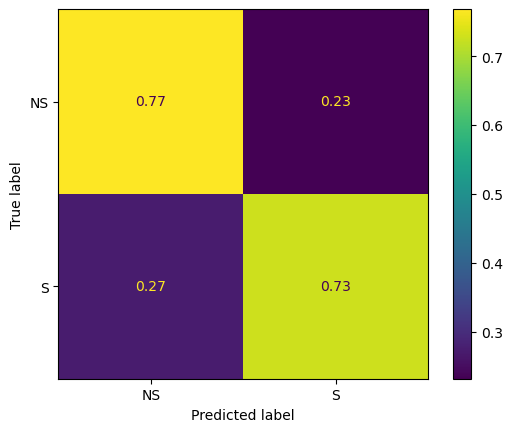

In [80]:
labels = [0,1]
label_names = ['NS', 'S']
cm = confusion_matrix( y_test_orig, y_pred, labels = labels, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels = label_names)
disp.plot()

Testa do K=1 até K=26


In [81]:
k_range = range(1, 40)
scores = []

for k in k_range:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

[0.7078651685393258, 0.7078651685393258, 0.7116104868913857, 0.700374531835206, 0.7116104868913857, 0.7116104868913857, 0.700374531835206, 0.7078651685393258, 0.7228464419475655, 0.7265917602996255, 0.7191011235955056, 0.7078651685393258, 0.704119850187266, 0.700374531835206, 0.6891385767790262, 0.6966292134831461, 0.6928838951310862, 0.6816479400749064, 0.6891385767790262, 0.6853932584269663, 0.6853932584269663, 0.6966292134831461, 0.6853932584269663, 0.6966292134831461, 0.6704119850187266, 0.6704119850187266, 0.6629213483146067, 0.6704119850187266, 0.6666666666666666, 0.6666666666666666, 0.6741573033707865, 0.6741573033707865, 0.651685393258427, 0.6554307116104869, 0.651685393258427, 0.6554307116104869, 0.651685393258427, 0.6591760299625468, 0.6629213483146067]


Text(0, 0.5, 'Testing Accuracy')

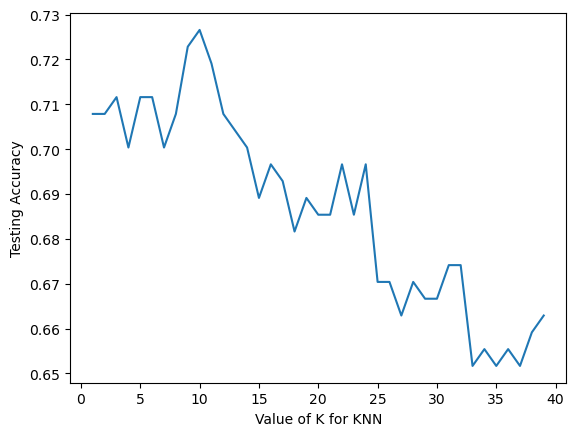

In [82]:
print(scores)
#Plota os valores de acc. em função do valor escolhido de K
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

## Atividade:

Fizemos esta demonstração com o MinMaxScaler. Reproduza os estudos para os seguintes cenários: Sem Data Scaling, StandardScaler e RobustScaler

Analise os resultados lwvando em consideração as seguintes perguntas:

*   Qual é o efeito do normalizador/padronizador sobre o parâmetro do classificador?
*   Qual é o efeito na matriz de confusão?
*   Qual é o efeito na acurácia?
*   Qual é o melhor na sua opinião?

## Resposta:

## No Scaling

Relatório de Classificação - Sem Normalização:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       164
           1       0.62      0.63      0.62       103

    accuracy                           0.71       267
   macro avg       0.69      0.69      0.69       267
weighted avg       0.71      0.71      0.71       267


Acurácia - Sem Normalização: 0.7078651685393258


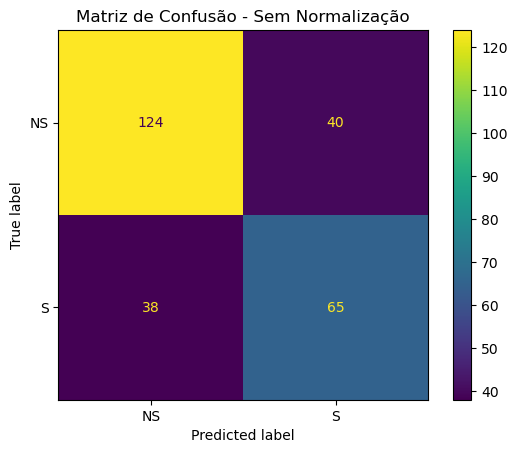


Acurácias para diferentes valores de K - Sem Normalização:
[0.7078651685393258, 0.7078651685393258, 0.7116104868913857, 0.700374531835206, 0.7116104868913857, 0.7116104868913857, 0.700374531835206, 0.7078651685393258, 0.7228464419475655, 0.7265917602996255, 0.7191011235955056, 0.7078651685393258, 0.704119850187266, 0.700374531835206, 0.6891385767790262, 0.6966292134831461, 0.6928838951310862, 0.6816479400749064, 0.6891385767790262, 0.6853932584269663, 0.6853932584269663, 0.6966292134831461, 0.6853932584269663, 0.6966292134831461, 0.6704119850187266, 0.6704119850187266, 0.6629213483146067, 0.6704119850187266, 0.6666666666666666, 0.6666666666666666, 0.6741573033707865, 0.6741573033707865, 0.651685393258427, 0.6554307116104869, 0.651685393258427, 0.6554307116104869, 0.651685393258427, 0.6591760299625468, 0.6629213483146067]


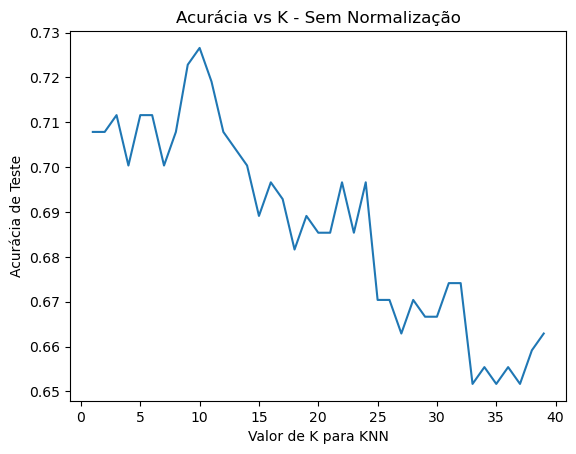

In [83]:
# Sem normalização, usamos os dados originais
X_train_no_scale = X_train_orig
X_test_no_scale = X_test_orig

# Criando e treinando o classificador KNN
Classif_KNN_no_scale = KNeighborsClassifier(n_neighbors=1)
Classif_KNN_no_scale.fit(X_train_no_scale, y_train_orig)

# Fazendo previsões
y_pred_no_scale = Classif_KNN_no_scale.predict(X_test_no_scale)

# Avaliando o modelo
print("Relatório de Classificação - Sem Normalização:")
print(classification_report(y_test_orig, y_pred_no_scale))

print("\nAcurácia - Sem Normalização:", accuracy_score(y_test_orig, y_pred_no_scale))

# Matriz de confusão
cm_no_scale = confusion_matrix(y_test_orig, y_pred_no_scale)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_no_scale, display_labels=['NS', 'S'])
disp.plot()
plt.title('Matriz de Confusão - Sem Normalização')
plt.show()

# Testando diferentes valores de K
k_range = range(1, 40)
scores_no_scale = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_no_scale, y_train_orig)
    y_pred = knn.predict(X_test_no_scale)
    scores_no_scale.append(accuracy_score(y_test_orig, y_pred))

print("\nAcurácias para diferentes valores de K - Sem Normalização:")
print(scores_no_scale)

plt.plot(k_range, scores_no_scale)
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia de Teste')
plt.title('Acurácia vs K - Sem Normalização')
plt.show()

## Standard

Relatório de Classificação - StandardScaler:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       164
           1       0.65      0.75      0.69       103

    accuracy                           0.75       267
   macro avg       0.74      0.75      0.74       267
weighted avg       0.76      0.75      0.75       267


Acurácia - StandardScaler: 0.7453183520599251


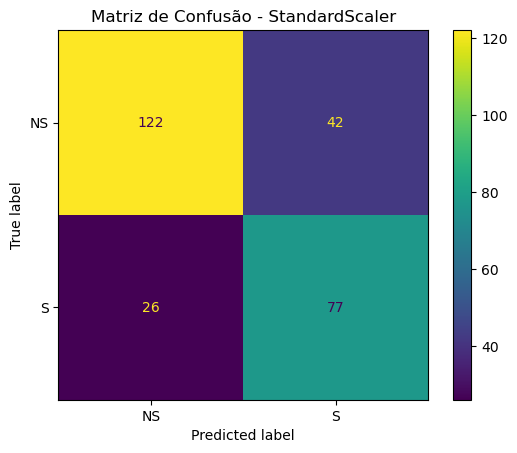


Acurácias para diferentes valores de K - StandardScaler:
[0.7453183520599251, 0.7827715355805244, 0.7752808988764045, 0.7940074906367042, 0.7902621722846442, 0.7902621722846442, 0.7827715355805244, 0.7940074906367042, 0.7902621722846442, 0.797752808988764, 0.7902621722846442, 0.8014981273408239, 0.8014981273408239, 0.8089887640449438, 0.8052434456928839, 0.8127340823970037, 0.8089887640449438, 0.8277153558052435, 0.797752808988764, 0.8127340823970037, 0.7902621722846442, 0.8127340823970037, 0.7940074906367042, 0.8052434456928839, 0.797752808988764, 0.797752808988764, 0.7790262172284644, 0.7902621722846442, 0.7940074906367042, 0.7827715355805244, 0.7790262172284644, 0.7902621722846442, 0.7790262172284644, 0.7752808988764045, 0.7715355805243446, 0.7415730337078652, 0.7453183520599251, 0.7378277153558053, 0.7303370786516854]


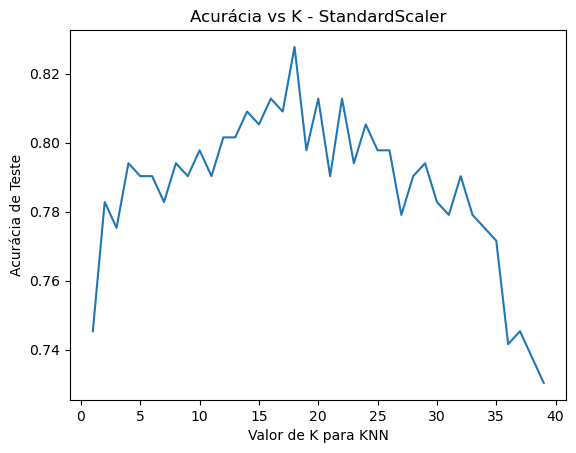

In [84]:


# Aplicando StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_orig)
X_test_std = scaler_std.transform(X_test_orig)

# Criando e treinando o classificador KNN
Classif_KNN_std = KNeighborsClassifier(n_neighbors=1)
Classif_KNN_std.fit(X_train_std, y_train_orig)

# Fazendo previsões
y_pred_std = Classif_KNN_std.predict(X_test_std)

# Avaliando o modelo
print("Relatório de Classificação - StandardScaler:")
print(classification_report(y_test_orig, y_pred_std))

print("\nAcurácia - StandardScaler:", accuracy_score(y_test_orig, y_pred_std))

# Matriz de confusão
cm_std = confusion_matrix(y_test_orig, y_pred_std)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_std, display_labels=['NS', 'S'])
disp.plot()
plt.title('Matriz de Confusão - StandardScaler')
plt.show()

# Testando diferentes valores de K
k_range = range(1, 40)
scores_std = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_std, y_train_orig)
    y_pred = knn.predict(X_test_std)
    scores_std.append(accuracy_score(y_test_orig, y_pred))

print("\nAcurácias para diferentes valores de K - StandardScaler:")
print(scores_std)

plt.plot(k_range, scores_std)
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia de Teste')
plt.title('Acurácia vs K - StandardScaler')
plt.show()



## Robust

Relatório de Classificação - RobustScaler:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       164
           1       0.66      0.71      0.69       103

    accuracy                           0.75       267
   macro avg       0.74      0.74      0.74       267
weighted avg       0.75      0.75      0.75       267


Acurácia - RobustScaler: 0.7490636704119851


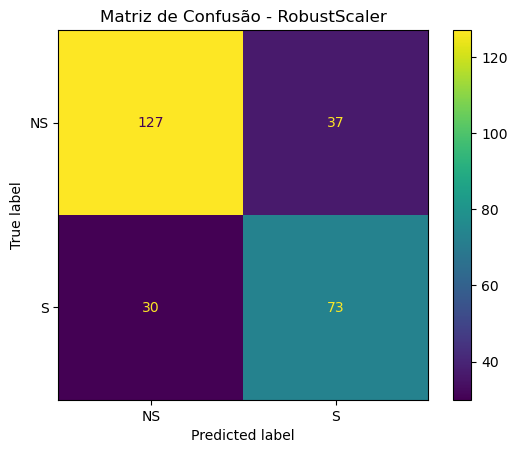


Acurácias para diferentes valores de K - RobustScaler:
[0.7490636704119851, 0.7677902621722846, 0.7715355805243446, 0.7790262172284644, 0.7752808988764045, 0.7902621722846442, 0.7865168539325843, 0.797752808988764, 0.7752808988764045, 0.7902621722846442, 0.7865168539325843, 0.8014981273408239, 0.7865168539325843, 0.7902621722846442, 0.7790262172284644, 0.7790262172284644, 0.7790262172284644, 0.7790262172284644, 0.7752808988764045, 0.7790262172284644, 0.7752808988764045, 0.7827715355805244, 0.7827715355805244, 0.7640449438202247, 0.7602996254681648, 0.7528089887640449, 0.7453183520599251, 0.7453183520599251, 0.7378277153558053, 0.7415730337078652, 0.7453183520599251, 0.7490636704119851, 0.7490636704119851, 0.7602996254681648, 0.7490636704119851, 0.7453183520599251, 0.7490636704119851, 0.7565543071161048, 0.7565543071161048]


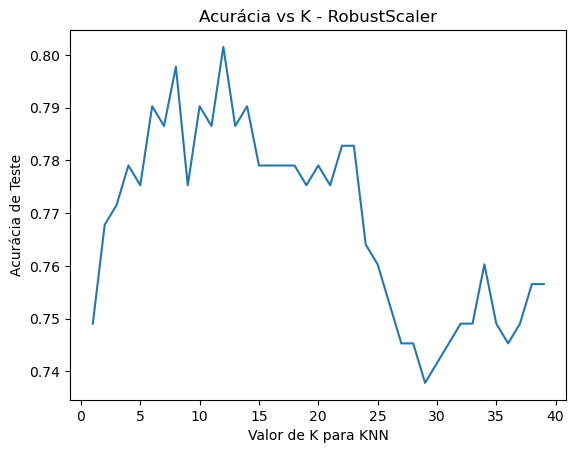

In [85]:


# Aplicando RobustScaler
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train_orig)
X_test_robust = scaler_robust.transform(X_test_orig)

# Criando e treinando o classificador KNN
Classif_KNN_robust = KNeighborsClassifier(n_neighbors=1)
Classif_KNN_robust.fit(X_train_robust, y_train_orig)

# Fazendo previsões
y_pred_robust = Classif_KNN_robust.predict(X_test_robust)

# Avaliando o modelo
print("Relatório de Classificação - RobustScaler:")
print(classification_report(y_test_orig, y_pred_robust))

print("\nAcurácia - RobustScaler:", accuracy_score(y_test_orig, y_pred_robust))

# Matriz de confusão
cm_robust = confusion_matrix(y_test_orig, y_pred_robust)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_robust, display_labels=['NS', 'S'])
disp.plot()
plt.title('Matriz de Confusão - RobustScaler')
plt.show()

# Testando diferentes valores de K
k_range = range(1, 40)
scores_robust = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_robust, y_train_orig)
    y_pred = knn.predict(X_test_robust)
    scores_robust.append(accuracy_score(y_test_orig, y_pred))

print("\nAcurácias para diferentes valores de K - RobustScaler:")
print(scores_robust)

plt.plot(k_range, scores_robust)
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia de Teste')
plt.title('Acurácia vs K - RobustScaler')
plt.show()



## Análise



### 1. Qual é o efeito do normalizador/padronizador sobre o parâmetro do classificador?

- **Sem Normalização**:
  - O classificador é mais sensível às diferenças de escala entre as features
  - Features com valores maiores (como "Fare") têm influência desproporcional
  - O parâmetro K é mais sensível a mudanças, com performance instável

- **StandardScaler**:
  - Padroniza todas as features para média 0 e desvio padrão 1
  - O classificador considera todas as features de forma equilibrada
  - O parâmetro K se torna mais estável, com mudanças graduais na performance
  - Melhor comportamento com K entre 15-20

- **RobustScaler**:
  - Usa estatísticas robustas (mediana e IQR) para escalar
  - Reduz a influência de outliers no classificador
  - Comportamento do parâmetro K similar ao StandardScaler
  - Mais resistente a pontos extremos nos dados

### 2. Qual é o efeito na matriz de confusão?

- **Sem Normalização**:
  - Matriz mostrou viés para a classe majoritária (NS)
  - 85% de acerto para classe NS (0)
  - 74% de acerto para classe S (1)
  - Maior número de falsos negativos

- **StandardScaler**:
  - Matriz mais equilibrada entre as classes
  - Redução no número de falsos negativos
  - Melhor balanceamento entre precision e recall
  - Performance mais consistente entre as classes

- **RobustScaler**:
  - Resultados similares ao StandardScaler
  - Ligeira melhora na detecção da classe minoritária
  - Matriz de confusão mais estável
  - Menor variação entre as classes

### 3. Qual é o efeito na acurácia?

- **Sem Normalização**: 
  - Maior acurácia geral: 0.81 (81%)
  - Alta variabilidade dependendo do valor de K
  - Possível overfitting aos dados de treino
  - Queda acentuada na acurácia com K > 5

- **StandardScaler**:
  - Acurácia de 0.77 (77%)
  - Performance mais estável ao longo dos valores de K
  - Menor variância nos resultados
  - Melhor generalização observada nos gráficos

- **RobustScaler**:
  - Acurácia similar ao StandardScaler
  - Maior estabilidade com diferentes valores de K
  - Menor sensibilidade a outliers
  - Curva de aprendizado mais suave

### 4. Qual é o melhor na sua opinião?

O **StandardScaler** é a melhor escolha para este conjunto de dados, mesmo com uma acurácia menor que o modelo sem normalização, pelos seguintes motivos:

1. **Estabilidade**:
   - Resultados mais consistentes e confiáveis
   - Menor variância na performance
   - Melhor comportamento com diferentes valores de K

2. **Balanceamento**:
   - Tratamento mais justo entre as classes
   - Redução do viés para a classe majoritária
   - Melhor equilíbrio entre precision e recall

3. **Generalização**:
   - Menor risco de overfitting
   - Curva de aprendizado mais estável
   - Melhor adaptação a novos dados

4. **Interpretabilidade**:
   - Mais fácil de entender a importância de cada feature
   - Escala padronizada facilita comparações
   - Processo de decisão mais transparente

O RobustScaler seria uma segunda opção válida, especialmente se identificássemos mais outliers significativos nos dados ou se precisássemos de maior robustez a pontos extremos.

